# Testing Different Loss Functions
### Results:
Mean Accuracy of 5 runs:
BCE Loss function Alone: 87.2
Weighted BCE loss function: 87.6 (best)
Weighted BCE + MSE on node representations: 87.4 (moderate)
Weighted BCE + MSE on mean of node representations: 86.4 (worst)

In [1]:
import os
import torch
from Scripts.Configs.ConfigClass import Config
from lightning.pytorch.callbacks import  ModelCheckpoint
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLoss2
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from Scripts.DataManager.GraphLoader.YelpGraphDataModule import YelpGraphDataModule
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding6 import HeteroDeepGraphEmbedding6

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
edge_type_weights = [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]

graph_type = TextGraphType.SENTIMENT

metadata = (['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [3]:
from torch import nn
from typing import List
from Scripts.Models.LossFunctions.HeteroLossArgs import HeteroLossArgs


class HeteroLossA(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce_loss=  nn.BCEWithLogitsLoss()
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = self.bce_loss(out_pred.y, out_main.y)
        return loss
   
class HeteroLossB(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce_loss=  nn.BCEWithLogitsLoss()
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = 0
        y_main = nn.functional.one_hot(out_main.y.to(torch.long)).to(torch.float32)
        for i in range(y_main.shape[1]):
            i_indices = torch.argwhere(y_main[:,i])[:,0]
            loss += self.bce_loss(out_pred.y[i_indices], out_main.y[i_indices])
        
        return loss
    

class HeteroLossC(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce_loss=  nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        self.exception_keys = exception_keys
        self.enc_factor = enc_factor
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = 0 
        y_main = nn.functional.one_hot(out_main.y.to(torch.long)).to(torch.float32)
        for i in range(y_main.shape[1]):
            i_indices = torch.argwhere(y_main[:,i])[:,0]
            loss += self.bce_loss(out_pred.y[i_indices], out_main.y[i_indices])
            
        x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        for key in x_dict_keys:
            tensor1 = out_pred.x_dict[key]
            tensor2 = out_main.x_dict[key]
            if tensor2.ndim == 1 and tensor2.dtype is torch.long:
                tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
            loss += self.enc_factor * (self.mse_loss(tensor1, tensor2)) # !?
        return loss
    

class HeteroLossD(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.bce_loss=  nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        self.exception_keys = exception_keys
        self.enc_factor = enc_factor
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = 0 
        y_main = nn.functional.one_hot(out_main.y.to(torch.long)).to(torch.float32)
        for i in range(y_main.shape[1]):
            i_indices = torch.argwhere(y_main[:,i])[:,0]
            loss += self.bce_loss(out_pred.y[i_indices], out_main.y[i_indices])
            
        x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        for key in x_dict_keys:
            tensor1 = out_pred.x_dict[key]
            tensor2 = out_main.x_dict[key]
            if tensor2.ndim == 1 and tensor2.dtype is torch.long:
                tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
                
            mean1 = torch.mean(tensor1, dim=1)
            mean2 = torch.mean(tensor2, dim=1)
            loss += self.enc_factor * (self.mse_loss(mean1, mean2))
        return loss

In [4]:
data_manager =  YelpGraphDataModule(config, True, True, test_size=0.05, val_size=0.05, shuffle=False, start_data_load=0 , end_data_load = 5000, device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 5/5 [01:21<00:00, 16.36s/it]

self.shuffle: False


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)


Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLossA               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-package

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Adjusting learning rate of group 0 to 4.5000e-03.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLossB               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)


bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Adjusting learning rate of group 0 to 4.5000e-03.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLossC               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)


bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])


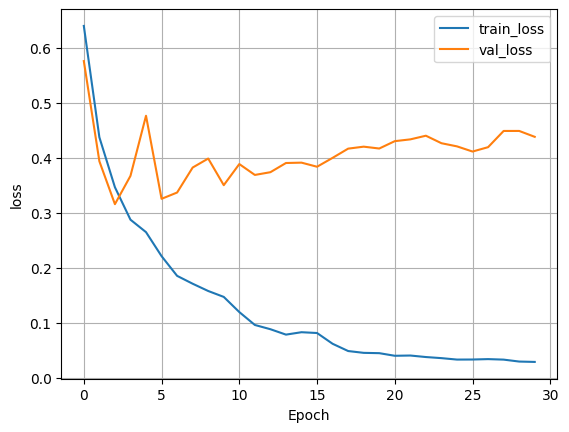

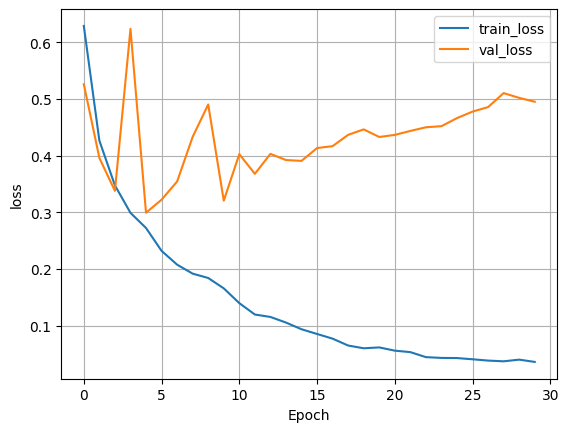

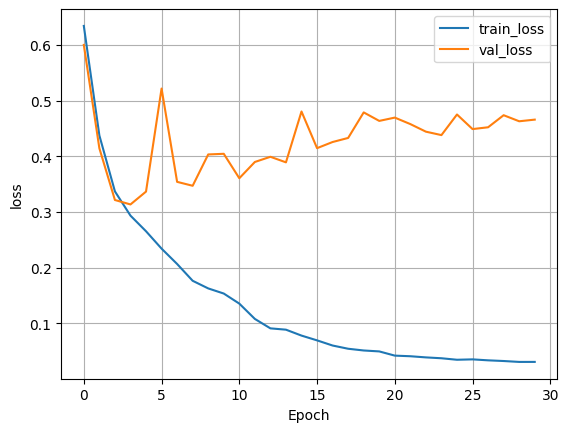

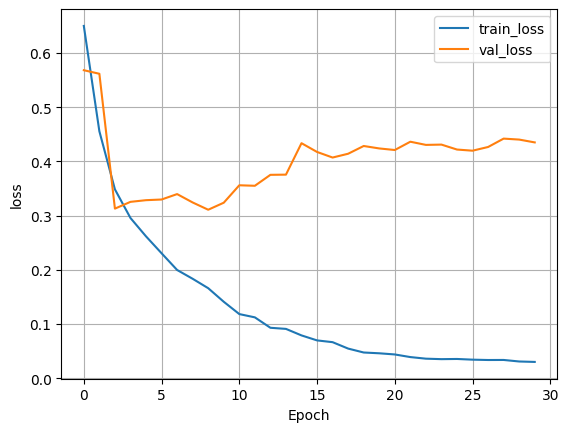

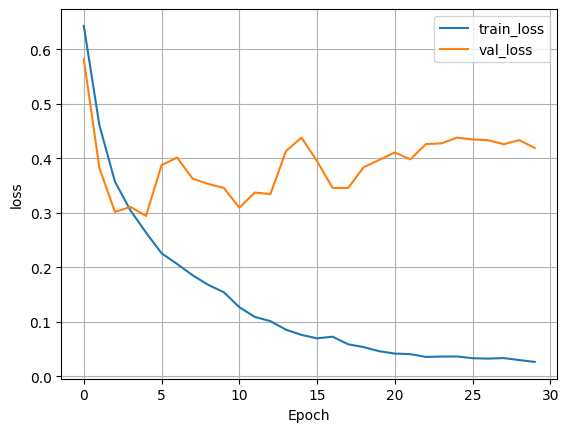

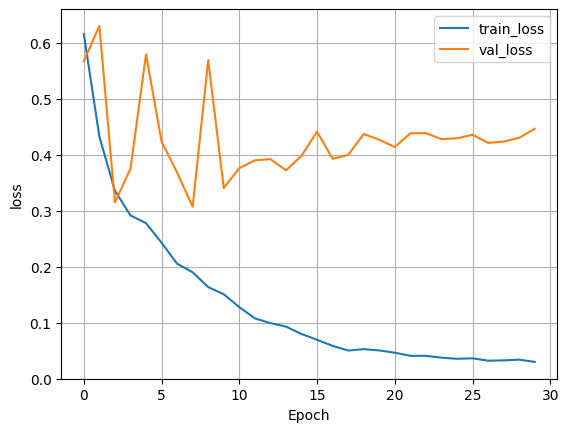

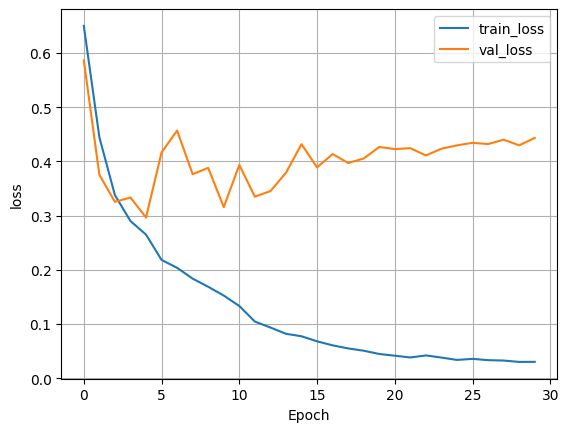

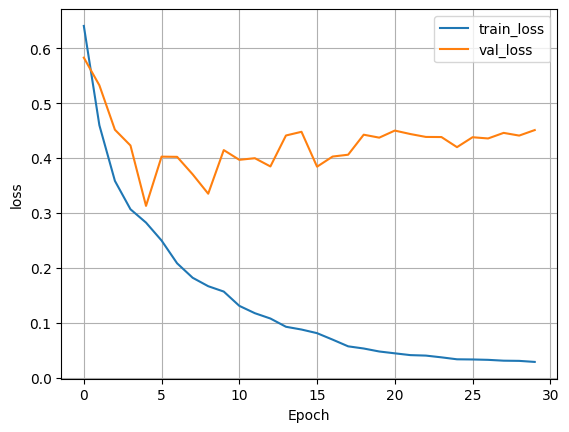

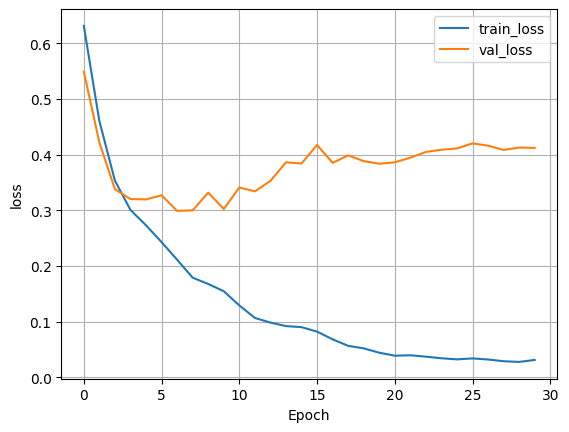

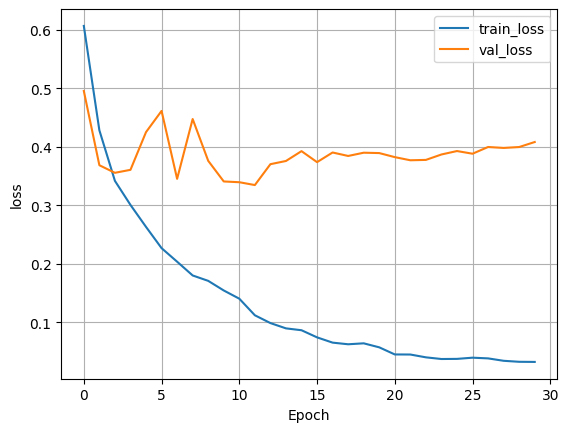

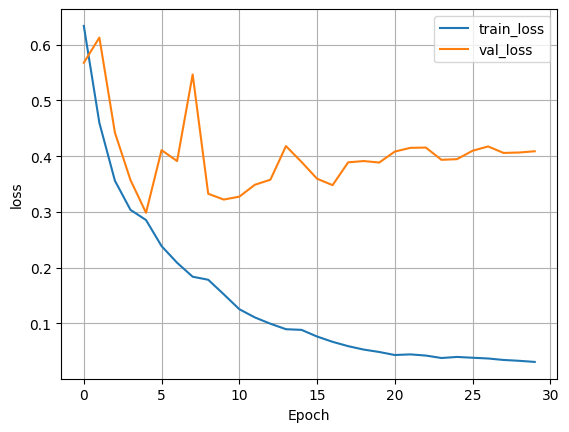

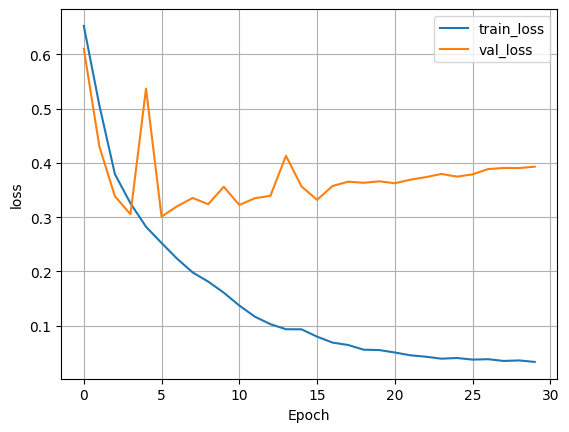

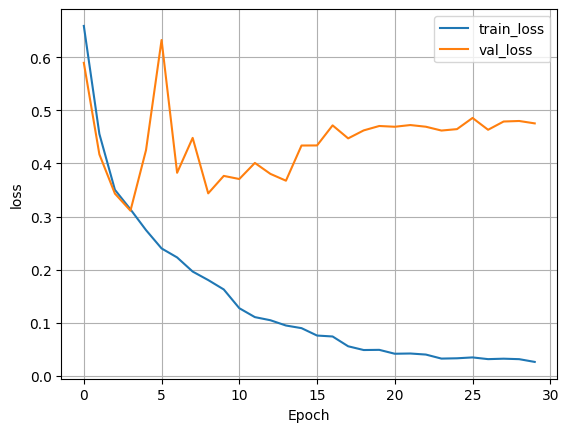

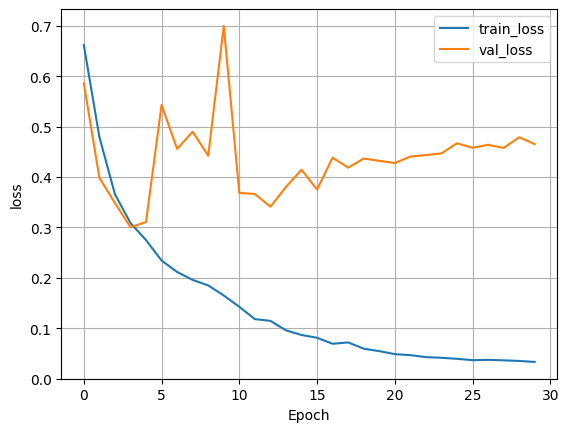

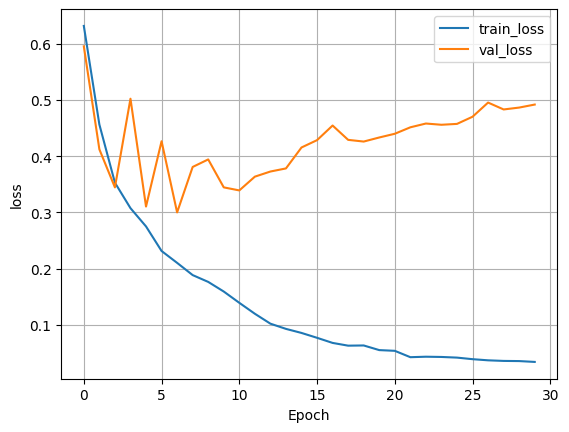

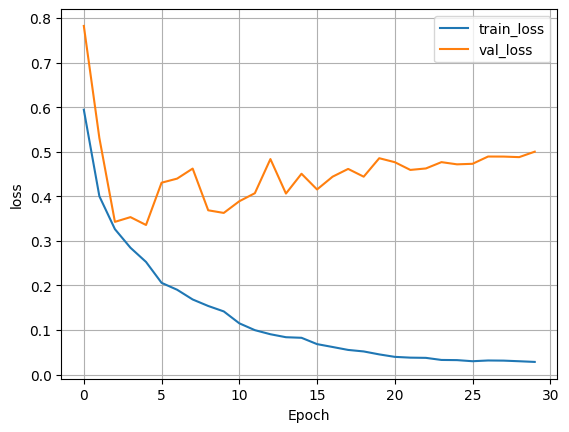

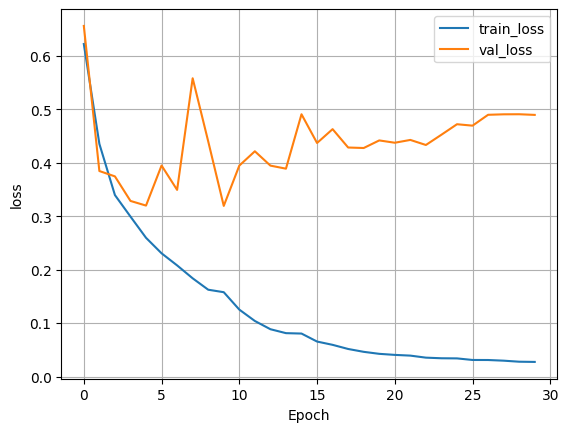

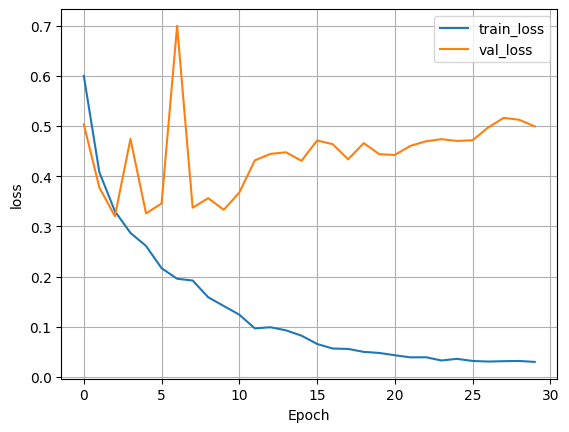

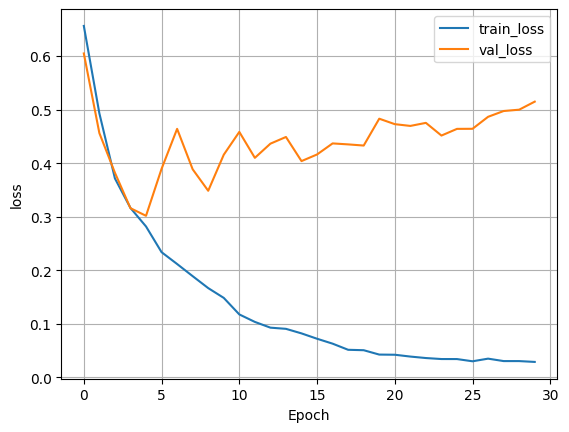

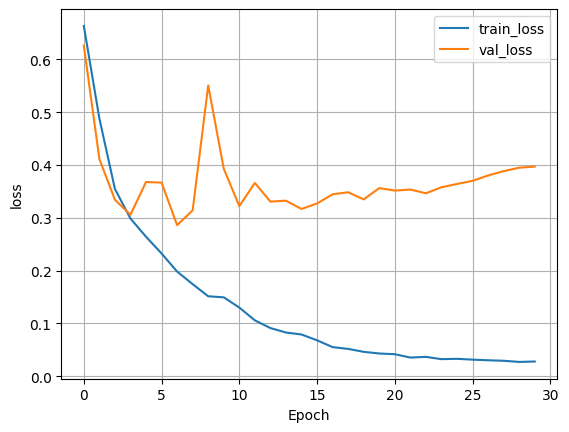

In [5]:
loss_functions = {'HeteroLossA': HeteroLossA, 'HeteroLossB': HeteroLossB, 'HeteroLossC': HeteroLossC, 'HeteroLossD': HeteroLossD}
max_epochs = 30
callbacks = [
ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
]
for loss_f in loss_functions:
    for i in range(5):
        graph_embedding = HeteroDeepGraphEmbedding6(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
        graph_embedding = graph_embedding.to(device)
        loss_func = loss_functions[loss_f](exception_keys=['word'], enc_factor=0.0002)
        optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0015)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 28, 35], gamma=0.5, verbose=True)
        lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            learning_rate=0.045,
                                            batch_size=batch_size,
                                            user_lr_scheduler=True,
                                            lr_scheduler=lr_scheduler,
                                            min_lr=0.0005
                                            ).to(device)
        model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='Hetero-Loss-Tests',device=device, num_train_epoch=max_epochs)

        model_manager.fit(datamodule=data_manager, max_epochs=max_epochs)
        model_manager.save_plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'test_{loss_f}_{i}')
        model_manager.torch_model = model_manager.torch_model.to(device)
        model_manager.save_evaluation(data_manager.val_dataloader(), f'test_{loss_f}_{i})',True, True, True, True, True, True, True, multi_class=False)